In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from numpy import mean, abs, power, pi, sin
from numpy.random import uniform, randint
from copy import deepcopy
from math import floor, ceil
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import KFold
from random import random

### Importing data

In [2]:
# to import the stored data
training = pd.read_csv('D:/tejas paper/final_training_df.csv')
training.head()

,Mean,SD,Kurtosis,sum,Skewness,max,min,range,RMS,Shape factor,condition
0,-1.166491,-0.641888,-0.631950,-1.166651,0.326382,-0.407618,1.058829,-0.740012,0.033720,-0.413015,5
1,0.389329,0.830822,1.604929,0.389247,0.082017,1.090784,-1.204128,1.196487,0.744678,-0.432032,3
2,1.439655,-0.488640,0.576646,1.439758,1.949726,0.773832,0.418404,0.236606,0.108506,-0.619835,1
3,-0.641116,-0.718663,-0.972769,-0.641185,-0.538460,-1.190899,0.873037,-1.093864,-0.003179,-0.486737,5
4,0.658361,-0.764562,-0.388668,0.658378,-0.370158,-0.387232,-0.437583,-0.008617,-0.024884,-0.598013,1


In [3]:
X_train = training.drop(['condition'], axis = 1)
Y_train = training['condition']

In [4]:
testing = pd.read_csv('D:/tejas paper/final_testing_df.csv')
testing.head()

,Mean,SD,Kurtosis,sum,Skewness,max,min,range,RMS,Shape factor,condition
0,-0.460915,-0.860746,-1.036939,-0.460855,-0.569580,-1.479807,1.343628,-1.483727,-0.071674,-0.520886,5
1,-0.224031,-0.100869,0.983163,-0.224191,0.073753,0.313520,-0.810453,0.567283,0.294995,-0.462754,4
2,-0.336128,0.531163,1.835477,-0.336130,2.019024,2.423654,-0.684162,1.700572,0.599914,-0.383252,4
3,0.331800,-0.372152,-0.920667,0.331941,-0.372720,-1.306980,0.615906,-1.035855,-1.967718,1.283732,0
4,0.415132,-0.535673,-0.822137,0.415019,-0.178914,-0.447551,0.309443,-0.402112,-1.968440,2.551908,0


In [5]:
X_test = testing.drop(['condition'], axis = 1)
Y_test = testing['condition']

### MSA

In [6]:
def initialize(N, dim):
    #if not isinstance(lb, list):
     #   lb = [lb for _ in range(dim)]
      #  ub = [ub for _ in range(dim)]
    #lb = np.asarray(lb)
    #ub = np.asarray(ub)
         
    #Initialize the locations of Harris' hawks
    #X = np.asarray([x*(ub-lb)+lb for x in uniform(0,1,(N, dim))])
    X = np.zeros((N, dim))
    
    reg_parameter = np.random.uniform(low = 0.0000001, high = 300, size = N)
    gam = np.random.uniform(low = 0.0000001, high = 50, size = N)

    for i in range(N):
        X[i, 0] = reg_parameter[i]
        X[i, 1] = gam[i]
    
    return X

In [7]:
def get_fitness(pos, X, Y):
    X = X.reset_index(drop=True)
    
    kf = KFold(n_splits = 10, random_state = None, shuffle = False)
    
    total_score = 0
    for train_index, test_index in kf.split(X):
        X_train_fold, X_cv_fold = X.iloc[train_index], X.iloc[test_index]
        Y_train_fold, Y_cv_fold = Y[train_index], Y[test_index]

        svm_model = SVC(C = pos[0], kernel='rbf', gamma = pos[1], verbose = False)
        svm_model.fit(X_train_fold, Y_train_fold)

        predicted_value = svm_model.predict(X_cv_fold)
        score = accuracy_score(Y_cv_fold, predicted_value)

        total_score = total_score + score
    
    acc = total_score/10
     
    return acc

In [8]:
def _levy_walk__(t, Smax):

        '''beta = 1.5      # Eq. 2.23 in paper
        sigma_N = math.gamma(1+beta) * np.sin(np.pi*beta/2)
        sigma_D = math.gamma((1+beta)/2) * beta * (2**((beta-1)/2))
        sigma = (sigma_N / sigma_D)**(1/beta)
        u = np.array([uniform(0.0000001), uniform(300)]) * sigma
        v = np.array([uniform(0.0000001), uniform(50)])
        step = np.divide(u, np.power(np.absolute(v),(1/beta)))'''
        sigma = 1.5
        L_num = (sigma-1)*math.gamma(sigma-1)*np.sin(np.pi*(sigma-1)/2)
        L_den = np.pi*np.power(t+1, sigma)
        L = L_num/L_den
        step = np.array([L, L])
        ## scale is same as alpha from eqn 2
        scale = Smax / ((t+1)**2)
        delta_x = scale * step
        
        return delta_x

In [9]:
def MSA_train(T, N, Smax, dim, X_train, Y_train):
    ## defining golden ratio and its array
    golden_ratio = (np.sqrt(5) - 1) / 2
    psi = np.array([golden_ratio, golden_ratio])
    
    #initialize locations
    pos = initialize(N, dim)
    pop = pd.DataFrame(columns = ('position', 'fitness'), index = [i for i in range(0, N)])
    for i in range(0, N):
        pop.iloc[i, 0] = pos[i, :]
        pop.iloc[i, 1] = 0
    
    # initialize convergence
    convergence_curve = np.zeros(T)
    
    for t in range(T):
        for i in range(0, N):
            # Check boundries          
            pop.iloc[i, 0][0] = np.clip(pop.iloc[i, 0][0], 0.0000001, 300)
            if pos[i, 1] < 0:
                pop.iloc[i, 0][1] = -pop.iloc[i, 0][1]
            else:
                pop.iloc[i, 0][1] = np.clip(pop.iloc[i, 0][1], 0.0000001, 50)
                
            # fitness of locations
            pop.iloc[i, 1] = get_fitness(pop.iloc[i, 0], X_train, Y_train)
            
        # sorting the population from lowest fitness to highest fitness
        pop = pop.sort_values('fitness', ignore_index = True)
        
        # best moth is the one that has highest fitness i.e. the last one after sorting in ascending order
        bestLocation = pop.iloc[N-1, 0]
        bestFitness = pop.iloc[N-1, 1]
        
        # updating subpopulation 1 using levy flight according to equation 2
        # function _levy_walk__ returns alpha*L(s)
        for i in range(int(ceil(N/2))):
            X1 = pop.iloc[i, 0] + _levy_walk__(t, Smax)
            X1[0] = np.clip(X1[0], 0.0000001, 300)
            if X1[1] < 0:
                X1[1] = -X1[1]
            #else:
            #    X1[1] = np.clip(X1[1], 0.001, 100)
            fit_X1 = get_fitness(X1, X_train, Y_train)
            
            # the moth is replaced only if its fitness is less than the new one
            if fit_X1 > pop.iloc[i, 1]:  ### line from mealpy inverted for maximisation
                pop.iloc[i, 0] = X1.copy()
                pop.iloc[i, 1] = fit_X1
        
        # updating subpopulation 2 using moths fly straightly eq 5 and 6
        for i in range(int(ceil(N/2)), N):
            lam = np.array([uniform(0.0000001, 300), uniform(0.0000001, 50)])
            #for j in range(dim):
            if uniform() > 0.5:
                X1 = lam * (pop.iloc[i, 0] + psi * (bestLocation-pop.iloc[i, 0]))
            else:
                X1 = lam * (pop.iloc[i, 0] + (1/psi) * (bestLocation-pop.iloc[i, 0]))
            X1[0] = np.clip(X1[0], 0.0000001, 300)
            if X1[1] < 0:
                X1[1] = -X1[1]
            #else:
            #    X1[1] = np.clip(X1[1], 0.001, 100)
            fit_X1 = get_fitness(X1, X_train, Y_train)
            
            # the moth is replaced only if its fitness is less than the new one
            if fit_X1 > pop.iloc[i, 1]:  ### line from mealpy inverted for maximisation
                pop.iloc[i, 0] = X1.copy()
                pop.iloc[i, 1] = fit_X1
        
        # replacing worst moth with the best one
        # this was implemented in mealpy
        pop.iloc[0, 0] = bestLocation
        pop.iloc[0, 1] = bestFitness
        
        # sorting newly updated  population
        pop = pop.sort_values('fitness', ignore_index = True)
        # best location from the updated population
        current_bestLocation = pop.iloc[N-1, 0]
        current_bestFitness = pop.iloc[N-1, 1]
        
        # replacing the previous best moth with new one only if its fitness is less than new one
        if bestFitness < current_bestFitness:
            bestLocation = current_bestLocation
            bestFitness = current_bestFitness
        
        convergence_curve[t] = bestFitness
                    
        if (t%1==0):
               print(f'At iteration {t} the best fitness is {bestFitness} and the best location is {bestLocation}')
    
    print(f'Best location is {bestLocation}')
    print(f'Best fitness is {bestFitness}')

    return convergence_curve, bestFitness, bestLocation

In [15]:
N = 50 # number of hawks
dim = 2
T = 50 # number of iterations
Smax = 0.5

MSA_train(T, N, Smax, dim, X_train, Y_train)

At iteration 0 the best fitness is 0.8800000000000001 and the best location is [291.49720885   1.53144576]
At iteration 1 the best fitness is 0.8800000000000001 and the best location is [291.49720885   1.53144576]
At iteration 2 the best fitness is 0.8800000000000001 and the best location is [291.49720885   1.53144576]
At iteration 3 the best fitness is 0.8800000000000001 and the best location is [291.49720885   1.53144576]
At iteration 4 the best fitness is 0.8800000000000001 and the best location is [291.49720885   1.53144576]
At iteration 5 the best fitness is 0.8800000000000001 and the best location is [291.49720885   1.53144576]
At iteration 6 the best fitness is 0.8800000000000001 and the best location is [291.49720885   1.53144576]
At iteration 7 the best fitness is 0.8800000000000001 and the best location is [291.49720885   1.53144576]
At iteration 8 the best fitness is 0.8800000000000001 and the best location is [291.49720885   1.53144576]
At iteration 9 the best fitness is 0.

(array([0.88 , 0.88 , 0.88 , 0.88 , 0.88 , 0.88 , 0.88 , 0.88 , 0.88 ,
        0.88 , 0.888, 0.888, 0.888, 0.888, 0.896, 0.896, 0.9  , 0.912,
        0.912, 0.936, 0.936, 0.936, 0.936, 0.936, 0.936, 0.936, 0.936,
        0.936, 0.936, 0.94 , 0.948, 0.948, 0.948, 0.948, 0.948, 0.948,
        0.948, 0.948, 0.948, 0.948, 0.948, 0.948, 0.948, 0.948, 0.948,
        0.948, 0.948, 0.948, 0.948, 0.948]),
 0.9480000000000001,
 array([3.00000000e+02, 5.07901663e-03]))

In [16]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

######### N=50, Smax=0.1
# C=300 gamma=0.0105767561 --> 10fold=94.4, training=97.2, testing=94, misclass_train=2.8%, misclass_test=6%
# C=300 gamma=0.009146268  --> 10fold=94.4, training=96.8, testing=92, misclass_train=3.2%, misclass_test=8%
# C=300 gamma=0.00491477312 --> 10fold=94.8, training=96.8, testing=90, misclass_train=3.2%, misclass_test=10%
# C=300 gamma=0.00957350201 --> 10fold=94.8, training=96.8, testing=92, misclass_train=3.2%, misclass_test=8%

######### N=50, Smax 0.5
# C=300 gamma=0.00519543538 --> 10fold=94.8, training=96.8, testing=90


######### N=50, Smax=0.75
# C=300 gamma=8.79699634e-03 --> 10fold=94.4, training=96.8, testing=92
# C=300 gamma=5.46827361e-03  --> 10fold=94.8, training=96.8, testing=90
# C=300 gamma=5.13813576e-03 --> 10fold=94.8, training=96.8, testing=90

######### N=100, Smax=0.1
# C=4.99795924 gamma=0.100356 --> 10fold=95.2, training=96.8, testing=90
# C=300 gamma=5.53272784e-03  --> 10fold=94.8, training=96.8, testing=90
# C= gamma=0.00491477312 --> 10fold=94.8, training=96.8, testing=90
# C= gamma=0.00957350201 --> 10fold=94.8, training=96.8, testing=92

######### N=100, Smax=0.5
# C=300 gamma=5.32959973e-03 --> 10fold=94.8, training=96.8, testing=90
# C= gamma=0.009146268  --> 10fold=94.4, training=96.8, testing=92
# C= gamma=0.00491477312 --> 10fold=94.8, training=96.8, testing=90
# C= gamma=0.00957350201 --> 10fold=94.8, training=96.8, testing=92

clf = SVC(kernel = 'rbf', C = 300, gamma = 5.07901663e-03, verbose = 1)
clf.fit(X_train, Y_train)

test_predicted_output = clf.predict(X_test)
train_predicted_output = clf.predict(X_train)

testing_accuracy = accuracy_score(Y_test, test_predicted_output)
training_accuracy = accuracy_score(Y_train, train_predicted_output)

print("The TESTING ACCURACY IS:- ", testing_accuracy)
print('The TRAINING ACCURACY IS:- ', training_accuracy)

[LibSVM]The TESTING ACCURACY IS:-  0.9
The TRAINING ACCURACY IS:-  0.968


In [12]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
  
    print("Number of misclassified points ",(len(test_y)-np.trace(C))/len(test_y)*100, '%')

 
    labels = [0,1,2,3,4,5]
    cmap=sns.light_palette("green")
  
    '''
    CONFUSION MATRIX
    '''
    print("-"*50, "Confusion matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

Number of misclassified points  3.2 %
-------------------------------------------------- Confusion matrix --------------------------------------------------


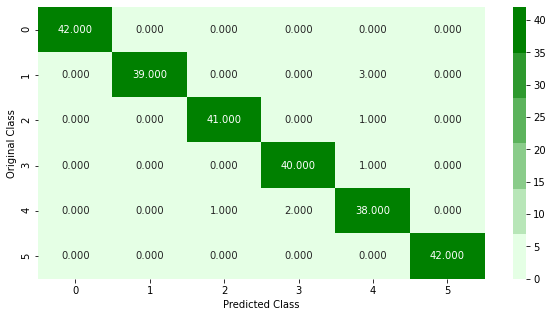

In [13]:
'''
FOR TRAINING DATA POINTS
'''
plot_confusion_matrix(Y_train, train_predicted_output)

Number of misclassified points  8.0 %
-------------------------------------------------- Confusion matrix --------------------------------------------------


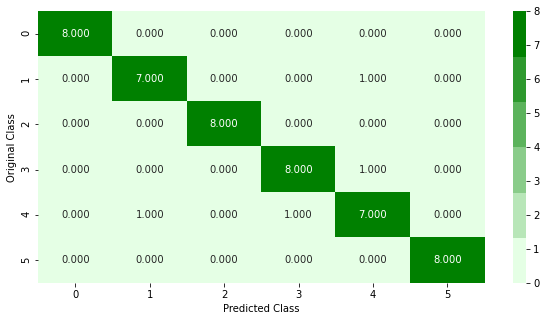

In [14]:
'''
FOR TESTING DATA POINTS
'''
plot_confusion_matrix(Y_test, test_predicted_output)